In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path


# Disable warnings
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Loading Data

Let's start by loading the data and configuring the data augmentation settings for training, validation, and testing.

### Input Shape Determination

The input shape for the neural network model will be determined based on the image data format. If the image data format is "channels_first," the input shape will be (3, 150, 150), indicating the number of channels (RGB) followed by the image dimensions. Otherwise, if the image data format is "channels_last," the input shape will be (150, 150, 3), indicating the image dimensions followed by the number of channels.


In [2]:
# Loading Data
dir_alldata = Path('../input/chest-xray-pneumonia/chest_xray/chest_xray')
train_data_dir = dir_alldata / 'train'
validation_data_dir = dir_alldata / 'val'
test_data_dir = dir_alldata / 'test'

img_width, img_height = 150, 150
nb_train_samples = 1000
nb_validation_samples = 100

epochs = 50
batch_size = 28

# Determine the input shape based on the image data format
if tf.keras.backend.image_data_format() == "channels_first":
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### Data Augmentation Configurations

For the training dataset, we will apply the following data augmentation techniques:
- Rescaling the pixel values to the range [0, 1]
- Randomly shearing the images
- Randomly zooming the images
- Randomly flipping the images horizontally

For the validation and test datasets, we will only rescale the pixel values to the range [0, 1] without applying other augmentations.

### Data Flow Generators

We will use data flow generators to generate the training, validation, and test data flows from their respective directories. These generators will handle loading the images, applying data augmentation, and providing the data in batches during model training and evaluation.
These data generators will efficiently load and augment the images, ensuring a smooth and efficient training and evaluation process.

In [3]:
# Define the data augmentation configurations for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# validation_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)


# Generate the data flow from the directory for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary"
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary"
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Data Visualization

To gain a better understanding of the dataset, let's visualize a sample image from each dataset (train, validation, and test) and also print the number of samples in each dataset.


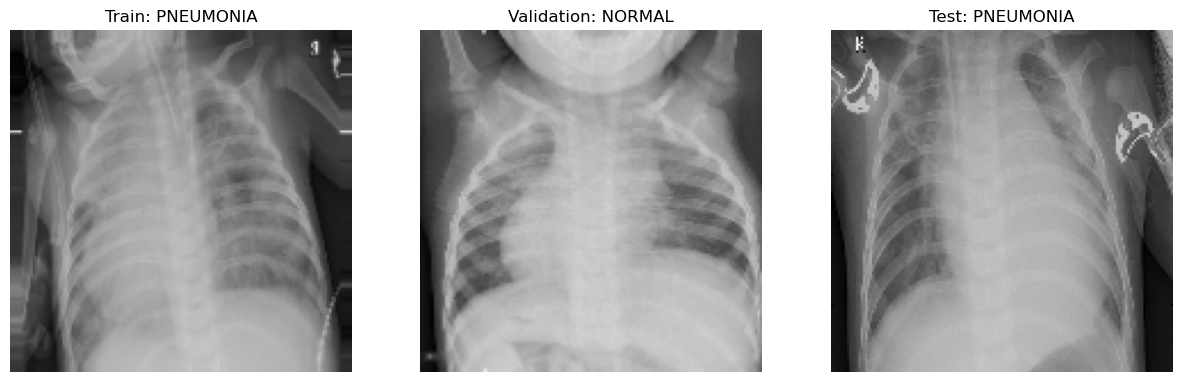

Number of samples in train dataset: 5216
Number of samples in validation dataset: 16
Number of samples in test dataset: 624


In [4]:
# Sample Images and Count of Samples in Each Dataset

# Get a sample batch from each dataset
train_sample_batch = next(iter(train_generator))
validation_sample_batch = next(iter(validation_generator))
test_sample_batch = next(iter(test_generator))

# Extract the images and labels from the sample batches
train_images, train_labels = train_sample_batch
validation_images, validation_labels = validation_sample_batch
test_images, test_labels = test_sample_batch

# Convert the labels from numerical to class names
class_names = ['NORMAL', 'PNEUMONIA']
train_labels = [class_names[int(label)] for label in train_labels]
validation_labels = [class_names[int(label)] for label in validation_labels]
test_labels = [class_names[int(label)] for label in test_labels]

# Plot the sample images from each dataset
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(train_images[0])
axes[0].set_title(f'Train: {train_labels[0]}')

axes[1].imshow(validation_images[0])
axes[1].set_title(f'Validation: {validation_labels[0]}')

axes[2].imshow(test_images[0])
axes[2].set_title(f'Test: {test_labels[0]}')

for ax in axes:
    ax.axis('off')

plt.show()

# Print the number of samples in each dataset
print(f"Number of samples in train dataset: {len(train_generator.filenames)}")
print(f"Number of samples in validation dataset: {len(validation_generator.filenames)}")
print(f"Number of samples in test dataset: {len(test_generator.filenames)}")


### Number of Samples in Each Dataset


- Number of samples in the train dataset: 5216
- Number of samples in the validation dataset: 16
- Number of samples in the test dataset: 624


## Model Building

In this section, we define and compile the convolutional neural network (CNN) model for pneumonia detection. The model architecture consists of convolutional layers, batch normalization, activation functions, max pooling, flattening, dense layers, dropout, and output layer.

We use the Sequential API from the Keras library to build the model. The layers are added one by one using the `model.add()` function. The `Conv2D` layers perform 2D convolution on the input images. Batch normalization is applied after each convolutional layer to normalize the activations. The activation function used is ReLU (Rectified Linear Unit), which introduces non-linearity to the model. Max pooling is applied after each activation layer to reduce the spatial dimensions. The `Flatten` layer converts the 2D feature maps to a 1D vector. Dense layers with batch normalization and ReLU activation are added to learn complex patterns in the data. Dropout is applied to prevent overfitting. The output layer has a single unit with a sigmoid activation function, which gives the probability of the input image belonging to the pneumonia class.

The model is compiled using the Adam optimizer and binary cross-entropy loss, as this is a binary classification problem. The accuracy metric is also specified for evaluation during training.

In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0

## Training the Model

In this section, we train the model on the training data and validate it on the validation data. We use the `fit_generator()` function to train the model with the specified number of epochs. The `train_generator` provides batches of augmented training data, and the `validation_generator` provides batches of validation data. We specify the number of steps per epoch and validation steps based on the number of samples and batch size.

In [6]:
opt = Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
history = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples // batch_size, epochs=epochs,
                              validation_data=validation_generator, validation_steps=nb_validation_samples // batch_size)


Epoch 1/50


2023-06-18 13:56:21.884174: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


35/35 [==============================] - 31s 540ms/step - loss: 0.5406 - accuracy: 0.8337 - val_loss: 2.4954 - val_accuracy: 0.5000
Epoch 2/50
35/35 [==============================] - 17s 489ms/step - loss: 0.2628 - accuracy: 0.8888
Epoch 3/50
35/35 [==============================] - 16s 462ms/step - loss: 0.3263 - accuracy: 0.8938
Epoch 4/50
35/35 [==============================] - 16s 449ms/step - loss: 0.2446 - accuracy: 0.9082
Epoch 5/50
35/35 [==============================] - 16s 442ms/step - loss: 0.2524 - accuracy: 0.9061
Epoch 6/50
35/35 [==============================] - 15s 424ms/step - loss: 0.2231 - accuracy: 0.9198
Epoch 7/50
35/35 [==============================] - 14s 407ms/step - loss: 0.1724 - accuracy: 0.9327
Epoch 8/50
35/35 [==============================] - 15s 419ms/step - loss: 0.2112 - accuracy: 0.9184
Epoch 9/50
35/35 [==============================] - 14s 396ms/step - loss: 0.2256 - accuracy: 0.9071
Epoch 10/50
35/35 [==============================] - 15s 421

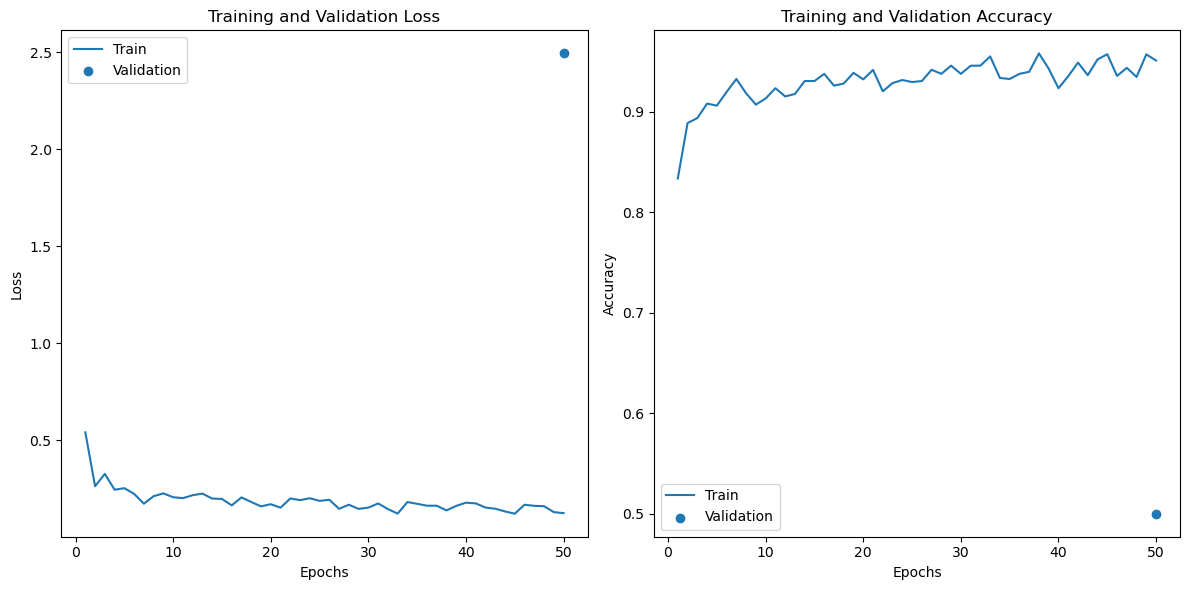

In [7]:
# Extract loss and accuracy values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting the learning curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss, label='Train')
plt.scatter(epochs, val_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_acc, label='Train')
plt.scatter(epochs, val_acc, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluating the Model

After training, we evaluate the model on the test data to assess its performance. We use the `evaluate_generator()` function to compute the test loss and accuracy. The `test_generator` provides batches of test data. The test loss represents the error of the model on the test data, and the test accuracy indicates the percentage of correctly classified test samples.

The test loss and accuracy are printed to the console for further analysis and comparison.

In [8]:
# Evaluate on the test set
# test_loss, test_accuracy = model.evaluate_generator(test_generator)
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

23/23 [==============================] - 7s 301ms/step - loss: 0.2709 - accuracy: 0.9054
Test Loss: 0.2709117829799652
Test Accuracy: 0.9054487347602844
